# ASTR 596: FDS Homework 7: Gaussian Processes


### Last week, you worked on finding periodic planet signals in the light curve of Kepler-90, a star that is photometrically stable. The periodogram worked nicely because 

### a) we cleaned the light curve to squelch red noise
### b) the signals really were periodic and we could implictly make a strong assumption about the covariance between points.

### Life gets harder when the star itself has quasi-periodic variations because it has a magnetic field and is rotating (ruh oh...) 

In [3]:
from matplotlib import pyplot as plt
import numpy as np

In [1]:
%matplotlib inline

from astropy.table import Table
tab = Table.read('KIC2157356.txt',format='ascii')
tab['quarter'] = tab['quarter'].astype('int')
tab

time,flux,error,quarter
float64,float64,float64,int64
539.4710179205795,5221.16455078125,4.891251087188721,6
539.4914521464307,5216.07958984375,4.892819404602051,6
539.5118864718097,5225.43359375,4.891888618469238,6
539.5323205971945,5233.111328125,4.892074108123779,6
539.5527548221144,5221.17333984375,4.891964435577393,6
539.573189147035,5220.09521484375,4.891523361206055,6
539.5936232714812,5222.14208984375,4.893854141235352,6
539.6140574957026,5224.57958984375,4.893648147583008,6
539.6344918194518,5223.78564453125,4.894421100616455,6


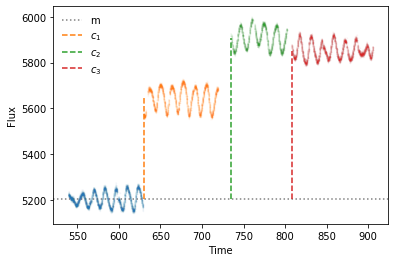

In [15]:
qs = sorted(np.unique(tab['quarter']))
means = []
cycle_map = {}
for i, q in enumerate(qs):
    ind = tab['quarter']==q
    t = tab[ind]
    plt.errorbar(t['time'],t['flux'], yerr=t['error'], marker='.', markersize=2, linestyle='None', alpha=0.02)
    meanflux = np.mean(t['flux'])
    cycle_map[q] = ind
    means.append(meanflux)
    if i == 0:
        plt.axhline(meanflux, label='m', color='grey', ls=":")
    else:

        vmin = means[0]
        vmax = meanflux

        plt.plot((t['time'][0], t['time'][0]), (vmin, vmax), label=rf'$c_{i}$', color=f'C{i}', ls='--') 
    
plt.xlabel('Time')
plt.ylabel('Flux')
plt.legend(frameon=False)

# plt.xlim([550,580])


### As you can see there is some kind of periodic singal, but it's not perfectly regular. There is also the usual offsets between Kepler photometry in different cycles.

### You'll need four parameters to describe constants ($m, c_1, c_2, c_3$) to renormalize the flux to the first cycle, illustrated in the figure above. 
### $m$ specifies the mean of the Gaussian process, while $c_1, c_2, c_3$ are nuisance parameters. 

### You know how to implement a model with one common zeropoint and multiple offsets - this was what you did on your midterm.


### You'll also need some model to describe the quasi-periodic oscillations. There's no good way to write down a model in real for these in real space because stellar magnetic fields are incredibly complicated. 

### Instead we'll write down a model for the covariance between the observations and use a Gaussian process to model the star. You can model quasi-periodic correlation structure as something periodic + something that varies the periodicity smoothly:

## $$k(t_i, t_j) = A\cdot \exp\left(-\Gamma_1\cdot \sin^2\left(\frac{\pi}{P}|t_i - t_j|\right) -  \frac{|t_i-t_j|^2}{\lambda}) \right) $$

### This is another 4 parameters, ($A, \Gamma_1, P, \lambda$) parameters for a total of 8: ($m, c_1, c_2, c_3, A, \Gamma_1, P, \lambda$)


<hr>

### Q1: To implement the GP correlations, use the `george` package to construct this quasi-periodic kernel
https://george.readthedocs.io/en/latest/user/kernels/


### In particular, you should be able to combine `ExpSine2Kernel` and `ExpSquaredKernel` to get a model for the quasi-periodic oscillations.

In [67]:
import george
from george import kernels
from george.modeling import Model

In [311]:

gamma = 10
P = 2.
lam = 2

k = kernels.ExpSine2Kernel(gamma,log_period=P)* kernels.ExpSquaredKernel(metric=lam)

### Q2: To implement the full model, read how to use `george`'s modeling protocol:
https://george.readthedocs.io/en/latest/tutorials/model/

### Determine the time range for each quarter

In [40]:
qs = sorted(np.unique(tab['quarter']))
quarter_end = np.zeros(4)

for i, q in enumerate(qs):
    ind = (tab['quarter']==q)
    quarter_end[i] =np.max(tab[ind]['time'])


### Creating a model for the mean value

In [117]:
class StepModel(Model):
    parameter_names = ("m", "c1", "c2", "c3")

    def get_value(self, t):
        t = t.flatten()
        return np.where(t<=quarter_end[0]+1e-6, self.m, \
                        np.where(t<=quarter_end[1]+1e-6, self.m+self.c1,\
                        np.where(t<=quarter_end[2]+1e-6, self.m+self.c2, self.m+self.c3,)))

### Get an estimate for m,c1,c2,c3

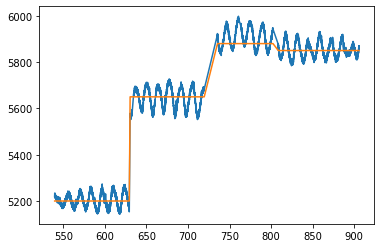

In [118]:
t = np.linspace(300,1000,200)

start = dict(m=5200, c1=450, c2=680, c3=650)

step = StepModel(**start).get_value(tab['time'])

plt.plot(tab['time'], tab['flux'])
plt.plot(tab['time'], step)

In [365]:
# select only nth data points
nth = 50
tab_select = tab[::nth]

t = tab_select['time']
y = tab_select['flux']
yerr = tab_select['error']


gp = george.GP(np.var(y)*k, mean=StepModel(**start), fit_mean=True)
gp.compute(t, yerr)

### Q3: With your model and likelihood constructured, write down priors on the parameters (you should be able to estimate from the plots)

### Define a flat prior for the last four parameter

In [367]:
def lnprob(p):    
    # Trivial uniform prior.
    if np.any((-300 > p[4:]) + (p[4:] > 300)):
        return -np.inf
    
    gp.set_parameter_vector(p)
    return gp.log_likelihood(y, quiet=True) 

In [368]:
print(gp.get_parameter_names())
gp.get_parameter_vector()

('mean:m', 'mean:c1', 'mean:c2', 'mean:c3', 'kernel:k1:log_constant', 'kernel:k2:k1:gamma', 'kernel:k2:k1:log_period', 'kernel:k2:k2:metric:log_M_0_0')


array([5.20000000e+03, 4.50000000e+02, 6.80000000e+02, 6.50000000e+02,
       1.12810151e+01, 2.00000000e+01, 6.00000000e+00, 2.00000000e+00])

In [369]:
lnprob(gp.get_parameter_vector())

-1414.5784517570148

### Q4: Use `emcee` to optimize the model parameters and hyper-parameters, **using only every 10th sample in time**
### (Don't go overboard with the number of walkers or steps)
https://george.readthedocs.io/en/latest/tutorials/hyper/ may help

In [370]:
import emcee

initial = gp.get_parameter_vector()
ndim, nwalkers = len(initial), 32
p0 = initial + 1e-2 * np.random.randn(nwalkers, ndim)
sampler = emcee.EnsembleSampler(nwalkers, ndim, lnprob)

print("Running burn-in...")
p0, _, _ = sampler.run_mcmc(p0, 100)
sampler.reset()

print("Running production...")
p0, _, _ = sampler.run_mcmc(p0, 1000,progress=True);

Running burn-in...


  0%|          | 0/1000 [00:00<?, ?it/s]

Running production...


100%|██████████| 1000/1000 [01:33<00:00, 10.72it/s]


In [378]:
# this cell can be used to add more mcmc if needed
print("Running production...")
p0,_, _ = sampler.run_mcmc(p0, nsteps=500, progress=True);
print("Chain shape:", sampler.chain.shape)

  0%|          | 0/500 [00:00<?, ?it/s]

Running production...


100%|██████████| 500/500 [00:39<00:00, 12.50it/s]

Chain shape: (32, 1800, 8)


In [145]:
def plot_chains(sampler, nburn, names):
    fig, ax = plt.subplots(8, figsize=(10, 15), sharex=True)
    for i in range(8):
        ax[i].plot(sampler.chain[:, :, i].T, '-k', alpha=0.2);
        ax[i].set_ylabel(names[i])
        ax[i].grid()
        
#         ax[i].axvspan(0,nburn,color='red',alpha=0.3,label='burn-in')
#         ax[i].legend()
        

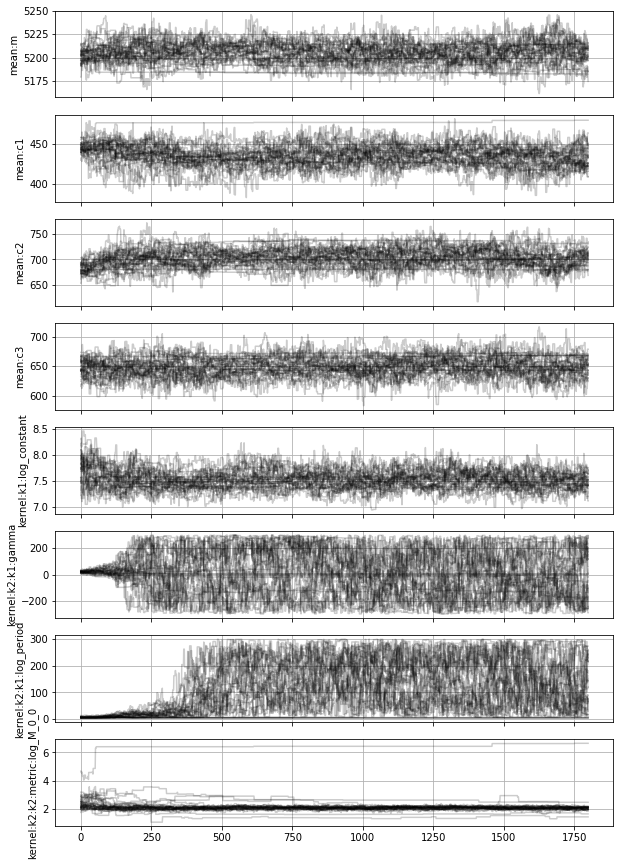

In [379]:
names = gp.get_parameter_names()
plot_chains(sampler, 100, names)

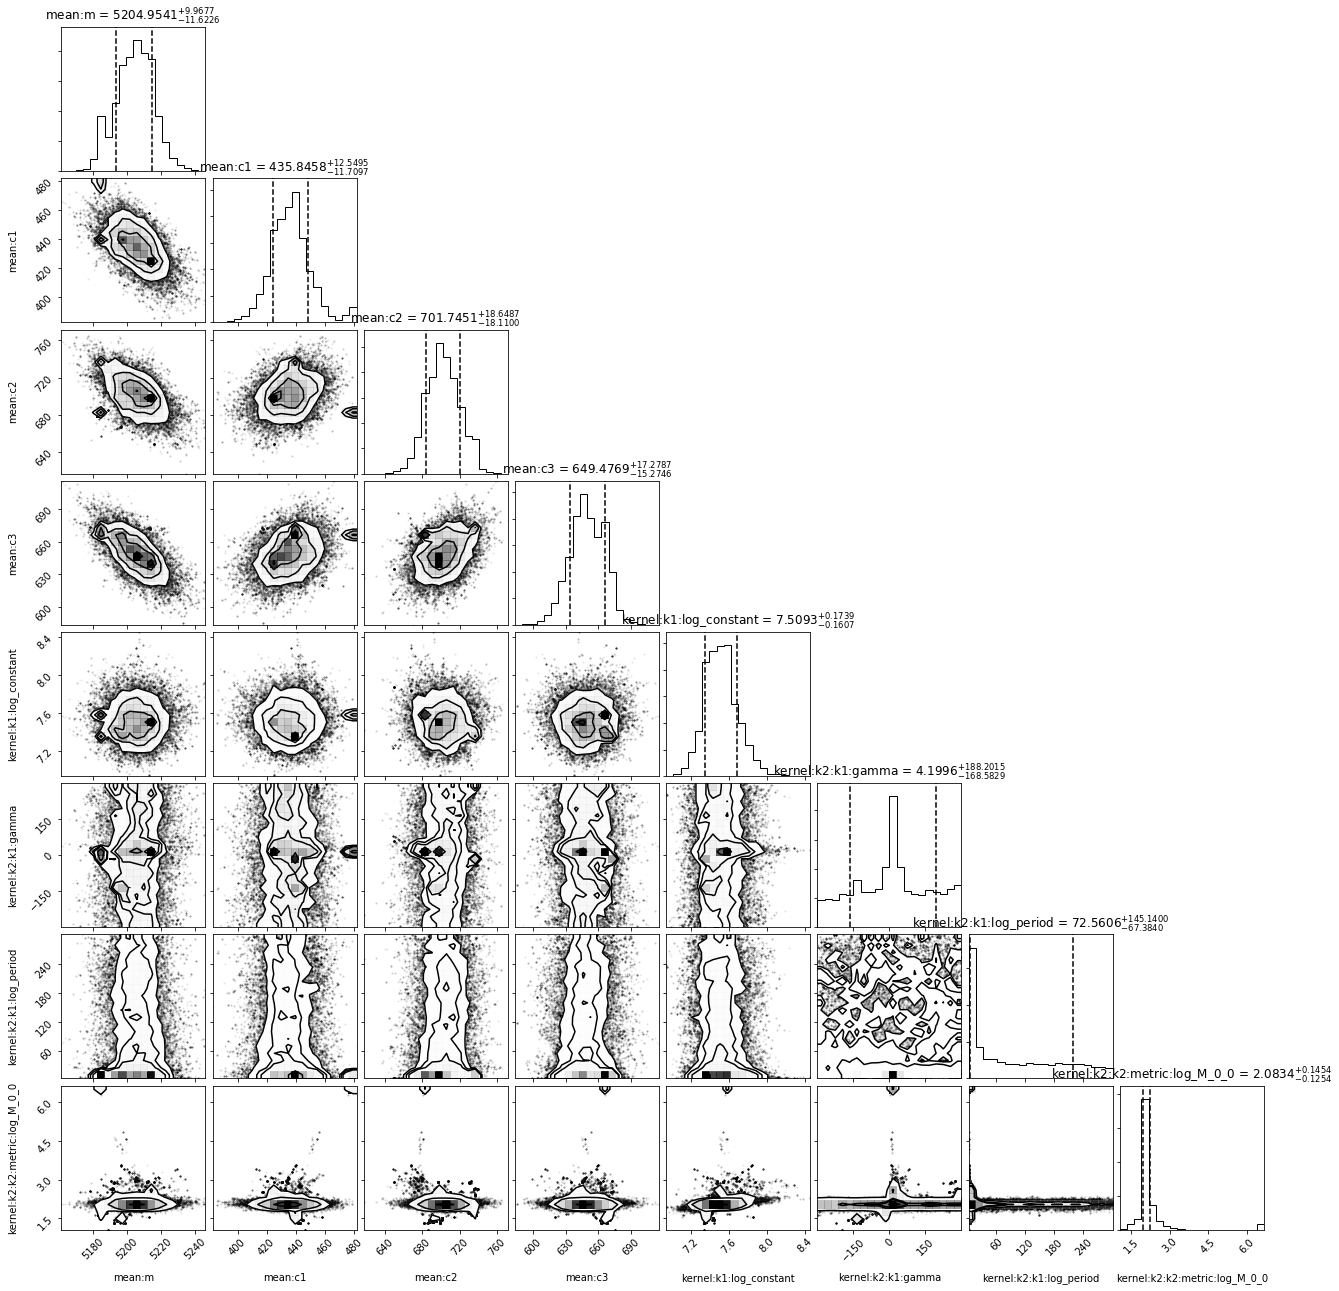

In [381]:
import corner

samples = sampler.get_chain(discard=0, flat=True,)
corner.corner(samples, labels=names, \
              quantiles=(0.16, 0.84), title_fmt='.4f', \
              show_titles=True,);

It seems that we cannot get a converge over the two kernel parameters.

In [383]:
p_bestfit = np.median(sampler.chain[:,], axis=(0,1))
print('Bestfit parameters:\n', p_bestfit)
print('LnL:', lnprob(p_bestfit))

Bestfit parameters:
 [5.20495407e+03 4.35845767e+02 7.01745083e+02 6.49476909e+02
 7.50926872e+00 4.19958422e+00 7.25606438e+01 2.08340329e+00]
LnL: -1190.9425013349826


### Q5: Plot your posterior model over the data after correcting for the offsets, showing the points you used to condition the GP in red, and the remaining data in black. 

In [393]:
def stepCorrect(t,m,c1,c2,c3):
    step = np.where(t<=quarter_end[0], m, np.where(t<=quarter_end[1], m+c1, \
                    np.where(t<=quarter_end[2], m+c2, m+c3 )))
    return step

step = stepCorrect(t, p_bestfit[0], p_bestfit[1], p_bestfit[2], p_bestfit[3],)
step_full = stepCorrect(tab['time'], p_bestfit[0], p_bestfit[1], p_bestfit[2], p_bestfit[3],)

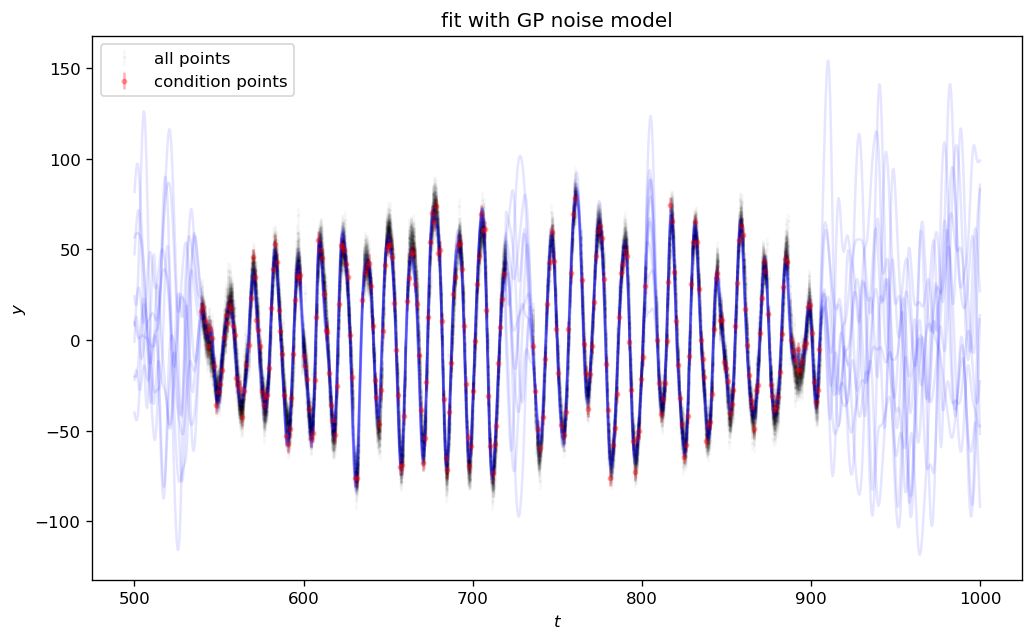

In [400]:
# Plot the data.
fig, ax = plt.subplots(figsize=(10,6), dpi=120)

plt.errorbar(tab['time'], tab['flux']-step_full, yerr=tab['error'], fmt=".k", markersize=2, linestyle='None', alpha=0.03, label='all points')
plt.errorbar(t, y-step, yerr=yerr, fmt=".r", markersize=5, linestyle='None', alpha=0.3, label='condition points')

# The positions where the prediction should be computed.
x = np.linspace(500, 1000, 1000)
xstep = stepCorrect(x, p_bestfit[0], p_bestfit[1], p_bestfit[2], p_bestfit[3],)

# Plot 24 posterior samples.
samples = sampler.flatchain[-100:]
for s in samples[np.random.randint(len(samples), size=10)]:
    gp.set_parameter_vector(s)
    mu = gp.sample_conditional(y, x)
    plt.plot(x, mu-xstep, color="b", alpha=0.1)

plt.ylabel(r"$y$")
plt.xlabel(r"$t$")

plt.legend()

plt.title("fit with GP noise model");